In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import time
import os

from datasets.mnist import MNIST

from models.cae_model import CAE
from models.conv_model import CNN

from train import train_ae, train_cnn

from cem import ContrastiveExplanationMethod

In [2]:
dataset = MNIST(batch_size=64)
# dataset = FashionMNIST()

# Training the classifier

In [3]:
cnn = CNN(device="cpu")

train_cnn(cnn, dataset, iterations=20, lr=0.01, save_fn='mnist-cnn', device="cpu", load_path="models/saved_models/mnist-cnn.h5")

In [4]:
images, _ = dataset.get_batch()

output = cnn(images)

images = images.numpy()
output = output.detach().numpy()


D:\david\Coding\uva-fact-ai\models\conv_model.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = nn.functional.softmax(out)


# Training the autoencoder

This section trains the autoencoder which will be used as regularizer for the data space which the perturbations are found in.

In [ ]:
# Train or load autoencoder
cae = CAE(device="cpu")

train_ae(cae, dataset, iterations=10, save_fn="mnist-cae", device="cpu", load_path="models/saved_models/mnist-cae-no-rs.h5")

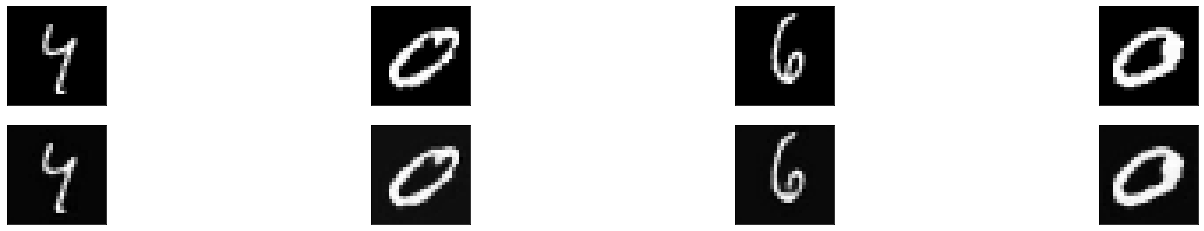

In [ ]:
# obtain one batch of test images
images, _ = dataset.get_batch()

#images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = cae(images + .5)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
# output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Contrastive Explanation Method

In [ ]:
kappa = 10
gamma = 100
beta = 0.1
lr = 0.1
CEM = ContrastiveExplanationMethod(cnn, cae, iterations=1000, n_searches=9, kappa=kappa, gamma=gamma, beta=beta, learning_rate=lr)

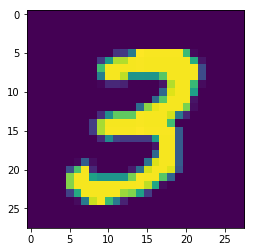

In [ ]:
# obtain one sample
image = dataset.get_sample_by_class(class_label=3, show_image=False)

plt.imshow(image.squeeze())

In [ ]:
# find pertinent negatives
mode = "PN"
CEM.fista(image, mode=mode)

search:0 iteration:0 lr:0.10 c value:10.00 loss: 98.46 delta sum:0.00 optimum:False y grad:-13.911
search:0 iteration:20 lr:0.10 c value:10.00 loss: 15694.15 delta sum:-4.73 optimum:False y grad:-7391.049
search:0 iteration:40 lr:0.10 c value:10.00 loss: 17544.69 delta sum:-15.07 optimum:False y grad:2288.994
search:0 iteration:60 lr:0.10 c value:10.00 loss: 18978.85 delta sum:-19.26 optimum:False y grad:-5069.271
search:0 iteration:80 lr:0.10 c value:10.00 loss: 18606.64 delta sum:-15.29 optimum:False y grad:-11291.536
search:0 iteration:100 lr:0.09 c value:10.00 loss: 19249.04 delta sum:-22.10 optimum:False y grad:-2777.761
search:0 iteration:120 lr:0.09 c value:10.00 loss: 18248.95 delta sum:-26.21 optimum:False y grad:-7988.075
search:0 iteration:140 lr:0.09 c value:10.00 loss: 18221.00 delta sum:-18.90 optimum:False y grad:-10649.554
search:0 iteration:160 lr:0.09 c value:10.00 loss: 17375.80 delta sum:-11.70 optimum:False y grad:-8832.442
search:0 iteration:180 lr:0.09 c value:10

search:1 iteration:500 lr:0.07 c value:100.00 loss: 16401.31 delta sum:-22.53 optimum:False y grad:-11283.601
search:1 iteration:520 lr:0.07 c value:100.00 loss: 17407.30 delta sum:-21.71 optimum:False y grad:-8200.927
search:1 iteration:540 lr:0.07 c value:100.00 loss: 15900.01 delta sum:-28.24 optimum:False y grad:-5461.118
NEW BEST: 15427.2822265625 - C: 100
search:1 iteration:560 lr:0.07 c value:100.00 loss: 15359.62 delta sum:-20.75 optimum:True y grad:-11397.081
search:1 iteration:580 lr:0.06 c value:100.00 loss: 16948.51 delta sum:-2.24 optimum:True y grad:-7609.821
search:1 iteration:600 lr:0.06 c value:100.00 loss: 18697.92 delta sum:-15.06 optimum:True y grad:-7682.330
search:1 iteration:620 lr:0.06 c value:100.00 loss: 18545.10 delta sum:-18.60 optimum:True y grad:-9401.584
search:1 iteration:640 lr:0.06 c value:100.00 loss: 17152.85 delta sum:-17.53 optimum:True y grad:-20590.916
search:1 iteration:660 lr:0.06 c value:100.00 loss: 18249.25 delta sum:-29.01 optimum:True y gr

In [ ]:
plt.imshow(image.squeeze())

In [ ]:
# perturbation
plt.imshow(image.squeeze()- CEM.best_delta.view(28,28), cmap="gray")
plt.show()
plt.imshow(CEM.best_delta.view(28,28) - image.squeeze(), cmap="gray")
plt.show()

In [ ]:
# original image with perturbation
plt.imshow(CEM.best_delta.view(28,28))

In [ ]:
for d in CEM.all_best:
    plt.imshow(d.view(28,28), cmap="gray")
    plt.show()
    plt.imshow(d.view(28,28) - image.squeeze(), cmap="gray")
    plt.show()

In [ ]:
# classification before
before = np.argmax(cnn(image.squeeze(-1)).detach()).item()
before

In [ ]:
# classification after
after = np.argmax(cnn(CEM.best_delta.view(1,28,28)).detach()).item()
after

In [ ]:
# classification of delta
class_delta = np.argmax(cnn(image.squeeze(-1) - CEM.best_delta.view(1,28,28)).detach()).item()
class_delta

In [ ]:
dirname = "saved_perturbations/mode-{}-kappa-{}-gamma-{}-beta-{}-lr-{}".format(mode, kappa, gamma, beta, lr)
os.makedirs(dirname, exist_ok=True)
fname_orig = dirname + "/{}-cb-{}-ca-{}-orig.png".format(int(time.time()), before, after)
fname_pert = dirname + "/{}-before-{}-after-{}-pert.png".format(int(time.time()), before, after)
fname_combined = dirname + "/{}-before-{}-after-{}-pn.png".format(int(time.time()), before, after)
fname_combined_pp = dirname + "/{}-before-{}-after-{}-pp.png".format(int(time.time()), before, after)
plt.imsave(fname_orig, image.squeeze(), cmap="gray")
plt.imsave(fname_pert, CEM.best_delta.view(28,28) - image.squeeze(), cmap="gray")
plt.imsave(fname_combined, CEM.best_delta.view(28,28), cmap="gray")
plt.imsave(fname_combined_pp, image.squeeze() - CEM.best_delta.view(28,28), cmap="gray")

In [ ]:
plt.imshow(cae(CEM.best_delta.view(1,1,28,28)+0.5).view(28,28).detach())

In [ ]:
plt.imshow(image.squeeze() - CEM.best_delta.view(28,28).detach())